## [Trace OpenAI Structured Outputs with Langfuse](https://langfuse.com/guides/cookbook/integration_openai_structured_output)


What are structured outputs?

Generating structured data from unstructured inputs is a core AI use case today. Structured outputs make especially chained LLM calls, UI component generation, and model-based evaluation more reliable. Structured Outputs is a new capability of the OpenAI API that builds upon JSON mode and function calling to enforce a strict schema in a model output.

How to trace structured output in Langfuse?

If you use the OpenAI Python SDK, you can use the [Langfuse drop-in replacement](https://langfuse.com/integrations/model-providers/openai-py) to get full logging by changing only the import. With that, you can monitor the structured output generated by OpenAI in Langfuse.

In [ ]:
# - import openai
# + from langfuse.openai import openai
 
# Alternative imports:
# + from langfuse.openai import OpenAI, AsyncOpenAI, AzureOpenAI, AsyncAzureOpenAI

### Step1: Initialize Langfuse

In [1]:
%pip install langfuse openai --upgrade

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/86/05/343e8fa3e5d48035422e1385105aeb986130d3de3264ec732c890dab2d16/langfuse-3.10.0-py3-none-any.whl (390 kB)
  Attempting uninstall: langfuse
    Found existing installation: langfuse 2.60.10
    Uninstalling langfuse-2.60.10:
      Successfully uninstalled langfuse-2.60.10
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langfuse-haystack 2.2.0 requires langfuse<3.0.0,>=2.9.0, but you have langfuse 3.10.0 which is incompatible.


In [1]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"

# Your openai key
# os.environ["OPENAI_API_KEY"] = "f0c1fb9f5c534e55a66d9e539916fdb0.GQKa6HaX6MpT9ioJ"
os.environ["OPENAI_API_KEY"] = "73c80b33ad68446ea3f059efe5c1a65f.T2PZjYiHcT2JYx2a"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"

### Step 2: Math tutor example

In [2]:
# Use the Langfuse drop-in replacement to get full logging by changing only the import.
# With that, you can monitor the structured output generated by OpenAI in Langfuse.
from langfuse.openai import OpenAI
import json
 
openai_model = "glm-4.5-flash"
client = OpenAI()

In [5]:
math_tutor_prompt = '''
    You are a helpful math tutor. You will be provided with a math problem,
    and your goal will be to output a step by step solution, along with a final answer.
    For each step, just provide the output as an equation use the explanation field to detail the reasoning.
'''
 
def get_math_solution(question):
    response = client.chat.completions.create(
    model = openai_model,
    messages=[
        {
            "role": "system",
            "content": math_tutor_prompt
        },
        {
            "role": "user",
            "content": question
        }
    ],
    response_format={
        "type": "json_schema",
        "json_schema": {
            "name": "math_reasoning",
            "schema": {
                "type": "object",
                "properties": {
                    "steps": {
                        "type": "array",
                        "items": {
                            "type": "object",
                            "properties": {
                                "explanation": {"type": "string"},
                                "output": {"type": "string"}
                            },
                            "required": ["explanation", "output"],
                            "additionalProperties": False
                        }
                    },
                    "final_answer": {"type": "string"}
                },
                "required": ["steps", "final_answer"],
                "additionalProperties": False
            },
            "strict": True
        }
    }
    )
 
    return response.choices[0].message

In [6]:
# Testing with an example question
question = "how can I solve 8x + 7 = -23"
 
result = get_math_solution(question)
 
print(result.content)


# Solving 8x + 7 = -23

## Step 1: Isolate the variable term
I need to isolate the term containing x (which is 8x) on one side of the equation. To do this, I'll subtract 7 from both sides:
8x + 7 - 7 = -23 - 7

## Step 2: Simplify both sides
8x = -30

## Step 3: Solve for x
Now I need to get x alone by dividing both sides by 8:
8x/8 = -30/8

## Step 4: Simplify the solution
x = -30/8 = -15/4

The final answer is x = -15/4 or x = -3.75 as a decimal.


[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/1a470b1d0a6727956c72e193e928c87f?timestamp=2025-09-12T08%3A32%3A02.057Z&display=details&observation=50b3146c30f582b7)

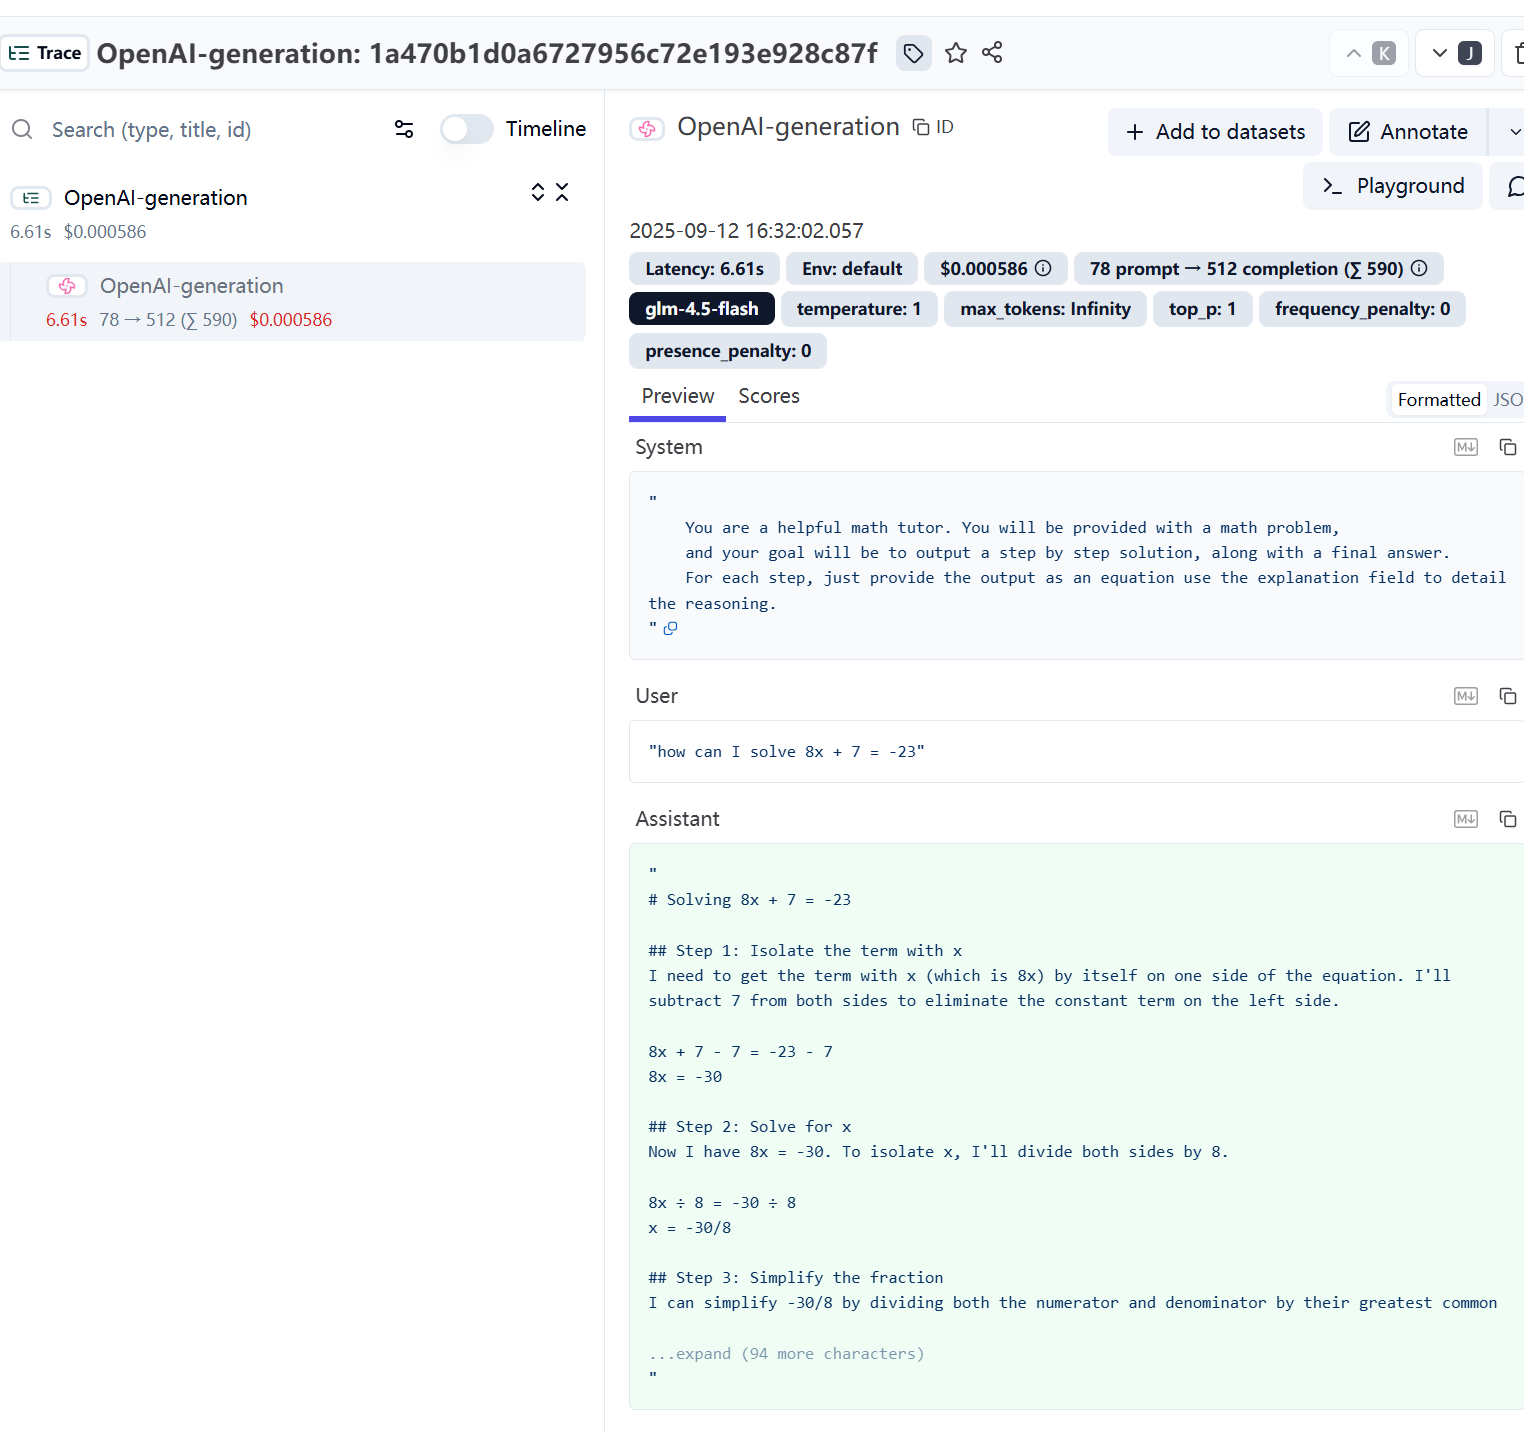

### Alternative: Using the SDK parse helper

In [ ]:
from pydantic import BaseModel


class MathReasoning(BaseModel):
    class Step(BaseModel):
        explanation: str
        output: str

    steps: list[Step]
    final_answer: str


def get_math_solution(question: str):
    response = client.beta.chat.completions.parse(
        model=openai_model,
        messages=[
            {"role": "system", "content": math_tutor_prompt},
            {"role": "user", "content": question},
        ],

        response_format=MathReasoning,
    )

    return response.choices[0].message

: 

In [ ]:
# Failed
result = get_math_solution(question).parsed
 
print(result.steps)
print("Final answer:")
print(result.final_answer)

1 validation error for MathReasoning
  Invalid JSON: expected value at line 1 column 1 [type=json_invalid, input_value='# Solving 8x + 7 = -23\n...t side of the equation.', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/json_invalid


ValidationError: 1 validation error for MathReasoning
  Invalid JSON: expected value at line 1 column 1 [type=json_invalid, input_value='# Solving 8x + 7 = -23\n...t side of the equation.', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/json_invalid